In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

# Understanding Visual Analytics with Statistics

Visual storytelling plays a significant role in the decision-making process, so, naturally, we hope our stories are sufficiently accurate, and they adequately represent the information from the available data. Unfortunately, being good at story-telling with numbers and graphs is not as intuitive as our inherent ability to make sense of the world through fundamental interactions and observations. 

Most frequently, we are interested in visualizing _univariate_ (one variable) and _bivariate_ (two variables) distributions, as well as discovering their mutual relations (comparisons between the variables). Here, we will look into three types of probabilities - _joint_, _marginal_, and _conditional_ - and show how different kinds of visualizations arise from those fundamental concepts.  

### Joint Probability Distribution

A Joint Probability expresses a likelihood of two different events occuring at the same time, for example, an event of _umbrella_ and an event of _rain_ (for a discrete case), or events representing _height_ and _weight_ (for a continious case). 

Mathematically, the joint probability distribution is expressed as:

$$f(x,y)=P(X=x,Y=y)$$

Let us generate two continious random variables and show how to visualize their joint probability distribution.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

%matplotlib inline

Generate 100 data points for two random variables, _a_ and _b_ normally distributed around 0.

In [45]:
df1 = pd.DataFrame(np.random.normal(loc=0, scale=0.1, size=(100, 2)), columns=["a", "b"])

In [46]:
df1.head()

,a,b
0,0.169400,0.023741
1,-0.047412,-0.017474
2,0.060392,0.059597
3,0.046378,0.011758
4,-0.026432,0.071529


Seaborn library provides a very convenient interface for computing the joint probability distribution for our random variables. By our generation method, we expect the significant mass of data points to be concentrated around 0 and slowly falling off. You can see that by observing the highest density in the center of the coordinate system, with each subsequent layer losing its intensity as it moves away from the center.

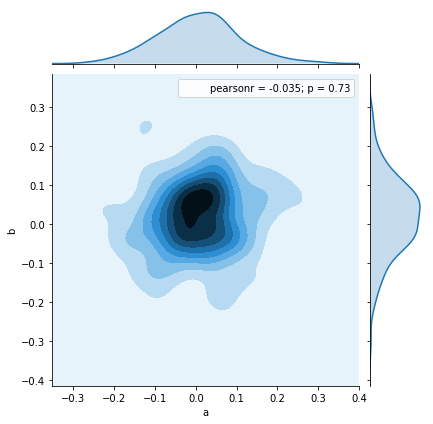

In [47]:
sns.jointplot(x="a", y="b", data=df1, kind='kde');

Let's do this for a discrete case as well, but this time select a different visualization technique.

In [48]:
df2 = pd.DataFrame(np.random.randint(low=1, high=4, size=(1000, 2)), columns=["a", "b"])
# dummy variable to facilitate counting
df2["frequency"] = 1

In [49]:
df2.head()

,a,b,frequency
0,1,1,1
1,3,3,1
2,3,1,1
3,3,1,1
4,2,1,1


Below we are going to compute the frequencies of variable's configurations occuring together. This is essentially the _unnormalized joint probability distribution_ (to normalize it, just divide it by their total number)

In [50]:
df_grouped = df2.groupby(["a", "b"])[["frequency"]].count().unstack("b")
# minor massage of the data to tidy up the column names
df_grouped.columns = df_grouped.columns.get_level_values(1)

In [51]:
df_grouped

b,1,2,3
a,,,
1,106,109,130
2,107,115,98
3,113,113,109


We are going to use _heatmap_ representation of the data to estimate the likelihood of each combinations of available states. We observe that the most likely state is the combination (1,3) and the less likely is (2,2). 

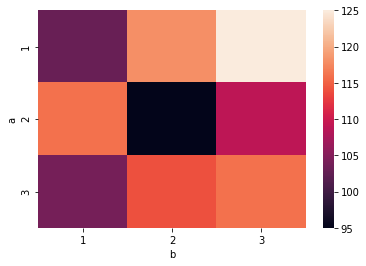

In [44]:
sns.heatmap(df_grouped);

Using just these two representations can help make sense of data, and accompany the decision making process with intuitive explanation of the reasoning. Now, let's us move on the the __marginal probability distribution__ that is computed from the joint probability distribution.

### Marginal Probability Distribution

This probability distribution might sound complicated, however, it is the most intuitive of the three because, in the end, it represents a single random variable irrespective of other variables. Every time we are computing a histogram of one variable, we are seeking its marginal distribution, where the variable is analyzed in isolation (therefore, other variables are being "marginalized"). 

Mathematically, the marginal probability is derived directly from the joint probability:

$$P(X=x) = \sum_{y}{P(X=x, Y=y)}$$

Our previous _joinplot_ generated for the continuous variables is handy for seeing the _marginals_ as well. It is captured by those "mounts" on the top and on the right side of the graph for variables _a_ and _b_ respectively. It is a "shop in one place" concept.

For the discrete case, we can obtain the marginal distribution by aggregating and slicing the corresponding events.

In [74]:
df_marg = df2.groupby("a")[["b"]].count() / df2.groupby("a")["b"].count().sum()

The simple bar-chart visualization is sufficient to communicate marginal probability distribution of the variable _a_. Sometimes, it is convenient to _stack_ the bars in order to convey to share of each state in the total space of available states for the given variable.

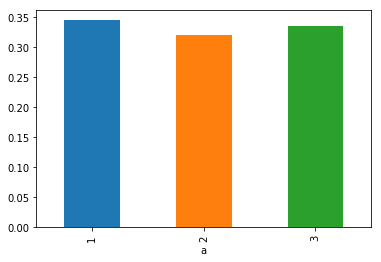

In [81]:
df_marg['b'].plot.bar();

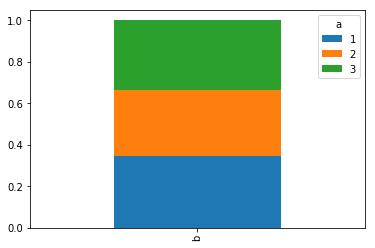

In [83]:
df_marg[['b']].T.plot.bar(stacked=True);

### Conditional Probability Distribution

Finally, let's look at the _conditional probability distribution_, that estimates a probability distribution of some variable $Y$ given $X$ is fixed to a particular state. This is useful when we already know the state of one variable (for example, it is raining outside), and we would like to estimate the probability of the certain state for the another variable that is _dependent_ of the first (for example, what is the probability of seeing an umbrella outside). 

Mathematically, the conditional distribution can be computed using joint and the marginal distribution:

$$P(X|Y) = \frac{P(X,Y)}{P(Y)}$$

In [99]:
cond_df = df2.groupby(['a', 'b'])[["frequency"]].count() / df2.groupby(['a', 'b'])["frequency"].count().sum()
cond_df.columns = ["probability"]

In [100]:
cond_df

probability
a b             
1 1        0.106
  2        0.109
  3        0.130
2 1        0.107
  2        0.115
  3        0.098
3 1        0.113
  2        0.113
  3        0.109

From here, you can look up any combination of states to get the conditional distribution of the desired configuration.

In [101]:
cond_df.loc[(1,1)]

probability    0.106
Name: (1, 1), dtype: float64

You can also find the _MAP_ (maximum a posteriori), or the most likely assignment. 

In [105]:
cond_df.probability.idxmax()

(1, 3)

The color-coded matrix with probability annotations is a convenient method to unravel a story behind the data by constrasting the most likely and the least likely configurations.

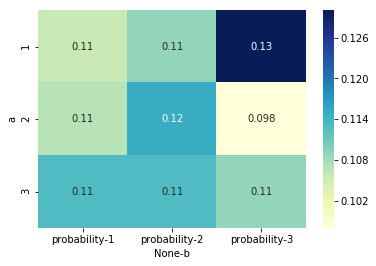

In [112]:
sns.heatmap(cond_df.unstack("b"), annot=True, cmap="YlGnBu");